In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import yfinance as yf
import fredapi as fa
from datetime import date, timedelta
from Exposure_Report import Exposure
import numpy as np
import matplotlib.pyplot as plt
import Useful_Functions as u
from statsmodels.tsa.stattools import adfuller
from scipy.stats.mstats import normaltest
import DataHub as da

fred = fa.Fred('4fb0ce271d0f66f4b5b3904b4aaf1dd0')

In [2]:

sector_df = da.get_Dataset('sec', ['real_yield', 'yield_curve'])

sector_df

,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Technology,Telecomm,Utilities,Real Estate,Energy,sp_500,real_yield,yield_curve
Date,,,,,,,,,,,,,,
2010-01-04,205.36,247.11,236.46,277.00,367.2600,197.79,376.4600,116.26,158.24,93.79,442.08,1132.9900,1.47,2.76
2010-01-05,206.43,247.99,237.62,276.70,365.1500,201.15,376.3300,116.64,156.51,94.04,445.60,1136.5200,1.43,2.76
2010-01-06,209.57,248.49,237.59,276.35,366.8900,202.00,373.0300,113.17,157.28,93.84,450.20,1137.1400,1.48,2.84
2010-01-07,208.61,251.72,239.63,276.28,368.2600,206.21,371.6000,112.21,156.43,94.95,449.20,1141.6899,1.44,2.82
2010-01-08,210.75,255.56,239.60,274.87,369.3500,205.09,374.5300,111.70,156.23,93.72,451.47,1144.9800,1.41,2.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,491.07,742.31,1075.20,728.27,1415.2100,522.78,2184.2900,183.65,343.53,244.81,636.32,3749.6299,0.69,0.03
2022-06-14,486.95,740.45,1072.55,718.89,1400.1400,517.85,2197.8501,183.13,334.65,242.34,636.74,3735.4800,0.89,0.04
2022-06-15,487.09,747.92,1104.97,719.48,1414.4500,524.26,2245.5601,187.46,336.92,247.99,623.21,3789.9900,0.63,0.13


In [3]:
import os

def get_path(end_item):
    
    item_list = ['Users', os.getlogin(), 'Desktop', '740', 'Reference_Data', end_item]
    
    # get_path('yuh.xlsx')
    path = ""
    
    for item in item_list:
        
        path = os.path.join(path, item)
        
    return path


sector_df.to_excel(get_path('yuh.xlsx'))

#get_path('yuh.xlsx')

OSError: Cannot save file into a non-existent directory: 'Users/root/Desktop/740/Reference_Data'

In [218]:
macro_data = ['nominal_yield', 'inflation', 'real_yield', 'yield_curve', 'economic_uncertainty',
                  'market_price', 'market_volume', 'market_volatility', 'cpi']
macro_cats = {'fred' : {'daily' : ['nominal_yield', 'inflation', 'real_yield', 'yield_curve', 'economic_uncertainty'],
                        'monthly' : ['cpi'], 
                        'quarterly' : []},
                'yahoo' : {'market_data' :{'Volume' : ['market_volume'],
                                    'Close' : ['market_price'],
                                    'Volatility' : ['market_volatility']}
                            },
                }
fred_ids = {'nominal_yield' : 'DGS10', 'inflation' : 'T10YIE', 'real_yield' : 'DFII10', 
            'yield_curve' : 'T10Y2Y', 'economic_uncertainty' : 'USEPUINDXD', 'cpi' : 'CPALTT01USM657N'}

starting_day_macro = "1962-01-02"


macro = pd.DataFrame()
for cat in macro_data:
            
    if cat in macro_cats['fred']['daily']:           
        macro[cat] = fred.get_series(fred_ids[cat], observation_start=starting_day_macro, end = date.today())
                
            # elif cat in macro_cats['fred']['monthly']:
    elif cat in macro_cats['fred']['monthly']:
        monthly = fred.get_series(fred_ids[cat], observation_start=starting_day_macro, end = date.today())
        macro[cat] = monthly
        macro[cat] = macro[cat].ffill().replace(np.nan, monthly[0])
    
    # Clean up above to handle more shit
    
    
    elif cat in macro_cats['yahoo']['market_data']['Volume']:
            
        macro[cat] = yf.download('^IXIC', start = starting_day_macro, progress=False)['Volume']
            
    elif cat in macro_cats['yahoo']['market_data']['Close']:
        
        macro[cat] = yf.download('^IXIC', start = starting_day_macro, progress=False)['Close']
            
    elif cat in macro_cats['yahoo']['market_data']['Volatility']:
                
        try:
            log_rets = pd.Series(np.log(macro['market_price']/macro['market_price'].shift()), index = macro.index)
        except:
            market_close = yf.download('^IXIC', start = starting_day_macro, progress=False)['Close']
            
            log_rets = pd.Series(np.log(market_close/market_close.shift()), index = macro.index)
            
        macro[cat] = log_rets.rolling(30).std()*252**.5
    
    else:
        pass

macro.index.name = 'Date'
#macro = round(macro.dropna(), 4)




,nominal_yield,inflation,real_yield,yield_curve,economic_uncertainty,market_price,market_volume,market_volatility,cpi
Date,,,,,,,,,
1962-01-02,4.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1962-01-03,4.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1962-01-04,3.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1962-01-05,4.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1962-01-08,4.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...
2022-06-13,3.43,2.74,0.69,0.03,95.98,10809.230469,5.912360e+09,NaN,0.558253
2022-06-14,3.49,2.60,0.89,0.04,112.83,10828.349609,4.802090e+09,NaN,0.558253
2022-06-15,3.33,2.70,0.63,0.13,138.85,11099.150391,5.346110e+09,NaN,0.558253


In [227]:


log_rets = pd.Series(np.log(macro['market_price']/macro['market_price'].shift()), index = macro.index).dropna()


#log_rets.rolling(30).std()*252**.5

log_rets

Date
1971-02-08    0.008365
1971-02-09   -0.000794
1971-02-10   -0.000695
1971-02-11    0.007520
1971-02-12    0.005897
                ...   
2022-06-13   -0.047938
2022-06-14    0.001767
2022-06-15    0.024701
2022-06-16   -0.041675
2022-06-17    0.014200
Name: market_price, Length: 12515, dtype: float64

In [250]:
sector_df = pd.read_csv("sector_data.csv", index_col="Date")
macro_df = pd.read_csv("macro_data.csv", index_col="Date")

time = '2010-01-04'

things_wanted = ['real_yield', 'yield_curve', 'cpi']

new_df = pd.concat([sector_df, macro_df[things_wanted]], axis = 1).dropna()

new_df.loc[new_df.index >= time]

,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Technology,Telecomm,Utilities,Real Estate,Energy,real_yield,yield_curve,cpi
Date,,,,,,,,,,,,,,
2010-01-04,205.36,247.11,236.46,277.00,367.2600,197.79,376.4600,116.26,158.24,93.79,442.08,1.47,2.76,-0.1761
2010-01-05,206.43,247.99,237.62,276.70,365.1500,201.15,376.3300,116.64,156.51,94.04,445.60,1.43,2.76,-0.1761
2010-01-06,209.57,248.49,237.59,276.35,366.8900,202.00,373.0300,113.17,157.28,93.84,450.20,1.48,2.84,-0.1761
2010-01-07,208.61,251.72,239.63,276.28,368.2600,206.21,371.6000,112.21,156.43,94.95,449.20,1.44,2.82,-0.1761
2010-01-08,210.75,255.56,239.60,274.87,369.3500,205.09,374.5300,111.70,156.23,93.72,451.47,1.41,2.87,-0.1761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,491.07,742.31,1075.20,728.27,1415.2100,522.78,2184.2900,183.65,343.53,244.81,636.32,0.69,0.03,0.5583
2022-06-14,486.95,740.45,1072.55,718.89,1400.1400,517.85,2197.8501,183.13,334.65,242.34,636.74,0.89,0.04,0.5583
2022-06-15,487.09,747.92,1104.97,719.48,1414.4500,524.26,2245.5601,187.46,336.92,247.99,623.21,0.63,0.13,0.5583


In [248]:

requested = ['nominal', 'real', 'yield_curve']

available_macro_data = list(pd.read_csv('macro_data.csv', index_col='Date').columns)



[False, False, True]

<AxesSubplot:>

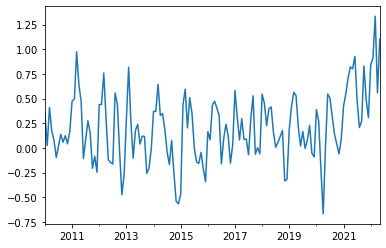

In [176]:

cpi = fred.get_series("CPALTT01USM657N", observation_start="2010-01-04")

sector_df = pd.read_csv("sectors_and_rates.csv", index_col="Date")
sector_df['inflation'] = pd.read_csv("macro_data.csv", index_col="Date")['inflation']
sector_df = sector_df.drop(columns = ['Real Yield'])
sector_df = sector_df.dropna()

cutoff = int(len(sector_df)*.9)

train_df = sector_df[:cutoff]

# ['Yield Curve', 'inflation']
# ['Real Yield', 'Yield Curve']
exposure = Exposure(sector_df, 252, 30, ['Yield Curve', 'inflation'], "SP-500")



In [188]:

lol = pd.read_csv("macro_data.csv", index_col="Date")

lol['cpi'] = fred.get_series("CPALTT01USM657N", observation_start="2010-01-01")

lol['cpi'] = lol['cpi'].ffill().replace(np.nan, cpi[0])

#lol.to_csv("macro_data.csv")


In [48]:


u.current_rates("d", True)



past month Real Yield, Yield Curve:



(5.0, -1.0)

In [158]:



def closest_combos(combo, in_index = False):

    assert isinstance(combo, tuple)
    
    min_error = 100
    errors = {}
    
    #tups = [(i,j) for i,j in zip(train_df['Real Yield_scores'], train_df['Yield Curve_scores'])]

    for rates in exposure.mean_return_combo.index:
        
        ry_error = abs(combo[0] - rates[0])
        yc_error = abs(combo[1] - rates[1])
        error = ry_error + yc_error
         
        errors[rates] = error
        
        if error <= min_error and error > 0:
            min_error = error
    
    mins = list(filter(lambda x: errors[x]==min_error, errors))
    
    if in_index:
        mins.append(combo)
    
    if len(mins) <= 2:
        
        more_mins = list(filter(lambda x: errors[x]==min_error+1, errors))
        
        extended = list( set(mins).union(set(more_mins)) )
        
        if len(extended) <= 3:
            
            even_more_mins = list(filter(lambda x: errors[x]==min_error+2, errors))
            
            return list( set(more_mins).union(set(even_more_mins)) )
        
        return extended
    
    return mins




<AxesSubplot:xlabel='difference', ylabel='Utilities'>

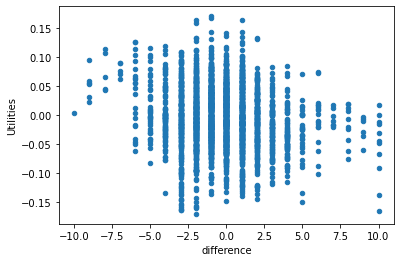

In [168]:

bruh = exposure.forward_returns_daily.copy()
bruh['difference'] = bruh['Yield Curve_scores'] - bruh['inflation_scores']
bruh.plot.scatter('difference', 'Utilities')


In [169]:


combo_df = exposure.mean_return_combo.copy()

combo_df['distance'] = [abs(i[0] - i[1]) for i in combo_df.index ]
combo_df['difference'] = [i[0] - i[1] for i in combo_df.index ]
combo_df['mean'] = [ (i[0] + i[1])/2 for i in combo_df.index ]
combo_df.corr()


,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Technology,Telecomm,Utilities,Real Estate,Energy,distance,difference,mean
Materials,1.000000,0.112349,-0.143494,0.300869,0.104144,-0.136165,-0.333737,-0.271100,0.213789,0.105349,0.602211,0.366632,-0.295580,0.057776
Industrials,0.112349,1.000000,-0.420490,0.087459,-0.362827,0.692598,-0.426217,-0.056271,0.155561,0.208564,0.158558,-0.262482,-0.034031,-0.165091
Consumer Discretionary,-0.143494,-0.420490,1.000000,-0.571802,-0.103838,-0.304175,0.248928,-0.027663,-0.509708,-0.288247,-0.394399,0.213780,0.422101,-0.075396
Consumer Staples,0.300869,0.087459,-0.571802,1.000000,0.506089,-0.116512,-0.453467,-0.292516,0.778163,0.403445,0.224127,0.200241,-0.557593,-0.018158
Health Care,0.104144,-0.362827,-0.103838,0.506089,1.000000,-0.526270,-0.281773,-0.489377,0.442222,-0.045735,0.124778,0.522895,-0.183105,-0.050089
Financials,-0.136165,0.692598,-0.304175,-0.116512,-0.526270,1.000000,-0.409121,0.254781,-0.056543,0.132251,0.033310,-0.459644,-0.043310,0.131434
Technology,-0.333737,-0.426217,0.248928,-0.453467,-0.281773,-0.409121,1.000000,0.153264,-0.530987,-0.312613,-0.420084,-0.208493,0.305949,-0.053453
Telecomm,-0.271100,-0.056271,-0.027663,-0.292516,-0.489377,0.254781,0.153264,1.000000,-0.206221,0.069820,-0.037236,-0.501646,0.151661,0.165373
Utilities,0.213789,0.155561,-0.509708,0.778163,0.442222,-0.056543,-0.530987,-0.206221,1.000000,0.554959,0.245527,0.113921,-0.618767,-0.059305
Real Estate,0.105349,0.208564,-0.288247,0.403445,-0.045735,0.132251,-0.312613,0.069820,0.554959,1.000000,0.128564,-0.178176,-0.516671,-0.022824


In [171]:

ok = combo_df.loc[ combo_df.difference == 5]

#len(exposure.total_return_combo[])

ok

,,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Technology,Telecomm,Utilities,Real Estate,Energy,distance,difference,mean
0.0,-5.0,-0.032000,0.012462,0.016103,-0.015922,0.001859,-0.012077,0.017132,-0.001486,-0.035213,0.006230,-0.014670,5.0,5.0,-2.5
1.0,-4.0,-0.006844,0.006574,-0.030371,-0.033388,-0.000076,0.013511,0.033029,0.015203,-0.058434,-0.054685,-0.026954,5.0,5.0,-1.5
2.0,-3.0,0.008897,0.007730,0.010870,-0.028956,-0.025606,0.002439,0.017487,0.009743,-0.030536,-0.007249,0.016207,5.0,5.0,-0.5
3.0,-2.0,-0.012109,-0.001171,0.032111,-0.018396,-0.006470,-0.007574,0.002579,-0.004306,-0.020552,-0.029929,0.005989,5.0,5.0,0.5
4.0,-1.0,0.020010,0.010670,0.018167,-0.033011,-0.010410,-0.009500,0.020109,-0.019897,-0.038971,-0.050717,0.014731,5.0,5.0,1.5
5.0,0.0,0.018545,-0.021067,0.030690,-0.007214,0.009702,-0.054345,0.038132,-0.022054,-0.020694,-0.079960,-0.106078,5.0,5.0,2.5


<AxesSubplot:>

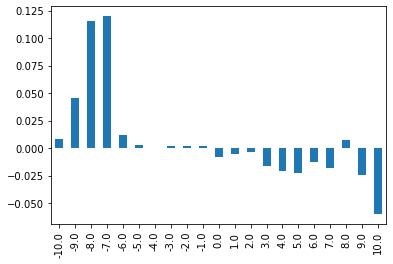

In [172]:


avg_dist = pd.DataFrame({i : combo_df.loc[ combo_df.distance == i].mean() for i in combo_df.distance.sort_values().unique()})
avg_dist = avg_dist.T

avg_diff = pd.DataFrame({i : combo_df.loc[ combo_df.difference == i].mean() for i in combo_df.difference.sort_values().unique()})
avg_diff = avg_diff.T


#plt.bar(avg_diff.index, avg_diff['Utilities'])
#plt.xlabel("Difference Between Real Yield Score and Yield Curve Score")

avg_diff["Consumer Staples"].plot.bar()



In [68]:


combo_df['Technology']


-5.0  -5.0    0.175235
      -4.0    0.128222
      -3.0    0.311272
      -2.0    0.149809
      -1.0    0.145880
                ...   
 5.0   5.0    0.101159
 6.0   2.0    0.054459
       3.0    0.044022
       4.0    0.046302
       5.0    0.078384
Name: Technology, Length: 107, dtype: float64

In [39]:


combo_data = exposure.mean_return_combo.copy()

close = closest_combos((5, -1))

close.append((5,2))
close.append((4,1))

similar_signal_means = combo_data.loc[close]

# .mean()
# .T.plot.bar(figsize = (25,15))
similar_signal_means.to_excel("for_joe.xlsx")
#plt.xticks(fontsize=18)

close

[(4.0, -1.0), (4.0, 0.0), (3.0, -1.0), (5.0, 1.0), (5, 2), (4, 1)]

In [44]:




exposure.total_return_combo[(4,-1)]



,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Technology,Telecomm,Utilities,Real Estate,Energy
Date,,,,,,,,,,,
2015-12-16,0.057264,0.075047,-0.050804,-0.065851,-0.133443,0.093980,0.022368,0.074433,0.038754,-0.088232,0.134669
2018-02-21,-0.139767,-0.070834,0.059719,-0.026775,-0.032309,-0.120735,0.095741,0.028291,0.097691,0.107843,-0.089883
